# Gender Pay Gap Analysis

The data for this project was obtained from [kaggle.com](kaggle.com). The original dataset can be found [here](https://www.kaggle.com/datasets/nilimajauhari/glassdoor-analyze-gender-pay-gap). The data was sourced from Glassdoor and comprises reported earnings for various job titles, classified by gender. The goal of this project is to explore the pay gap between men and women with the same job title. 

In [34]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import ttest_ind
import scipy

## Reading in the data

In [67]:
# Read in the dataset
df = pd.read_csv('glassdoor_gender_pay_gap.csv')

# Output the number of rows and columns
print(df.shape)

# Look at the first 5 rows
df.head()

(1000, 9)


,JobTitle,Gender,Age,PerfEval,Education,Dept,Seniority,BasePay,Bonus
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938
1,Software Engineer,Male,21,5,College,Management,5,108476,11128
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319


In [3]:
# Describe the dataframe
df.describe()

,Age,PerfEval,Seniority,BasePay,Bonus
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,41.393000,3.037000,2.971000,94472.653000,6467.161000
std,14.294856,1.423959,1.395029,25337.493272,2004.377365
min,18.000000,1.000000,1.000000,34208.000000,1703.000000
25%,29.000000,2.000000,2.000000,76850.250000,4849.500000
50%,41.000000,3.000000,3.000000,93327.500000,6507.000000
75%,54.250000,4.000000,4.000000,111558.000000,8026.000000
max,65.000000,5.000000,5.000000,179726.000000,11293.000000


In [4]:
# Check for null values
df.isna().sum()

JobTitle     0
Gender       0
Age          0
PerfEval     0
Education    0
Dept         0
Seniority    0
BasePay      0
Bonus        0
dtype: int64

Everything looks normal here; the ages range from 18 to 65, performance evaluations and seniority range from 1 to 5 as expected, base pay ranges from ~\\$34,000/year to ~\\$180,000/year, and bonuses range from ~\\$1,700 to ~\\$11,300. Each column has 1000 rows as expected and no null values, so it doesn't look like there's much to be done on the data cleaning front.

## Analyzing the data

### How does annual base pay differ between genders?

One way to look at all the data together is with a boxplot. What does the gap in annual base pay look like overall? What does it look like for each job?

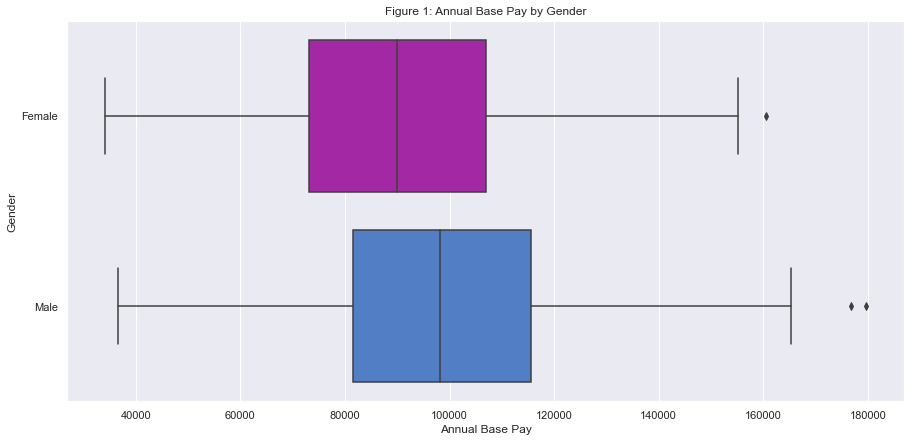

In [164]:
# Create color palette for plots
color_palette = {"Male": "#3F7AD8", "Female": "#B715B8"}

# Plot base pay by gender
plot = sns.boxplot(data=df, x="BasePay", y="Gender", palette = color_palette).set(title="Figure 1: Annual Base Pay by Gender", xlabel = "Annual Base Pay")
sns.set(rc={"figure.figsize":(15, 7)})

Overall, men have a slightly higher annual base pay than women across all jobs and departments. It would be valuable to perform a t-test to determine if this difference is statistically significant. We'll be doing this a lot, so we'll make it a function. 

In [40]:
# Function to perform t-test using scipy ttest_ind function
def perform_t_test(sample1, sample2):
    t_stat, p_value = ttest_ind(sample1, sample2)
    
    # Specify significance level
    alpha = 0.05
    
    if p_value < alpha:
        result = "Reject the null hypothesis; there is a significant difference between the sample means."
    else: 
        result = "Failed to reject the null hypothesis; there is no significant difference between the sample means."
        
    return result

# Split the df 
male_base_pay = df[df["Gender"] == "Male"]["BasePay"]
female_base_pay = df[df["Gender"] == "Female"]["BasePay"]

# Perform t-test
print(perform_t_test(male_base_pay, female_base_pay))

Reject the null hypothesis; there is a significant difference between the sample means.


This confirms that gender has an effect on base pay.

I believe that looking at individual jobs and departments will give us an idea of which ones have higher pay gaps, and if there are any with no pay gaps at all. This would represent the data better, as there may potentially be one or two jobs which are skewing the overall averages. 

#### How does annual base pay differ for individual job titles?

In [6]:
# Print the unique job titles
print(df['JobTitle'].unique())

['Graphic Designer' 'Software Engineer' 'Warehouse Associate' 'IT'
 'Sales Associate' 'Driver' 'Financial Analyst' 'Marketing Associate'
 'Data Scientist' 'Manager']


In [41]:
# Divide the jobs into 2 dataframes
df1 = df[df['JobTitle'].isin(['Graphic Designer', 'Software Engineer', 'Warehouse Associate', 'IT', 'Sales Associate'])]
df2 = df[df['JobTitle'].isin(['Driver', 'Financial Analyst', 'Marketing Associate', 'Data Scientist', 'Manager'])]

[Text(0.5, 0, 'Annual Base Pay')]

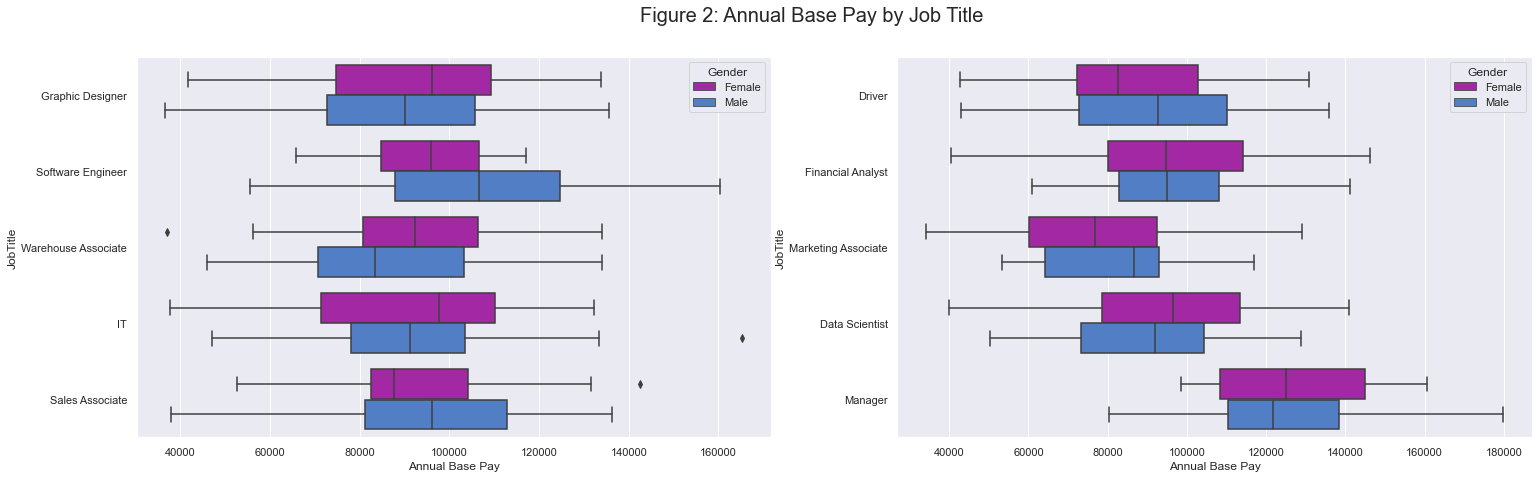

In [163]:
# Plot base pay by job
fig, axes = plt.subplots(1, 2, figsize = (25, 7), sharex = False, sharey = False)

fig.suptitle("Figure 2: Annual Base Pay by Job Title", fontsize = 20)

sns.boxplot(ax = axes[0], data=df1, x="BasePay", y="JobTitle", hue="Gender", palette = color_palette).set(xlabel = "Annual Base Pay")
sns.boxplot(ax = axes[1], data=df2, x="BasePay", y="JobTitle", hue="Gender", palette = color_palette).set(xlabel = "Annual Base Pay")

Interestingly, the overall pay gap we observed (men being paid more than women) is not reflected across the board when we look at individual jobs. For some jobs, the average annual base pay is higher for women, such as Graphic Designers, Warehouse Associates, IT, Data Scientists, and Managers. However, for most jobs where women have a higher average annual base pay, either... 
- the *maximum* annual base pay is lower for women (Graphic Designers, IT, Manager), or
- the *minimum* annual base pay is lower for women (IT, Data Scientist).

Another way to visualize these differences is with a boxplot. 

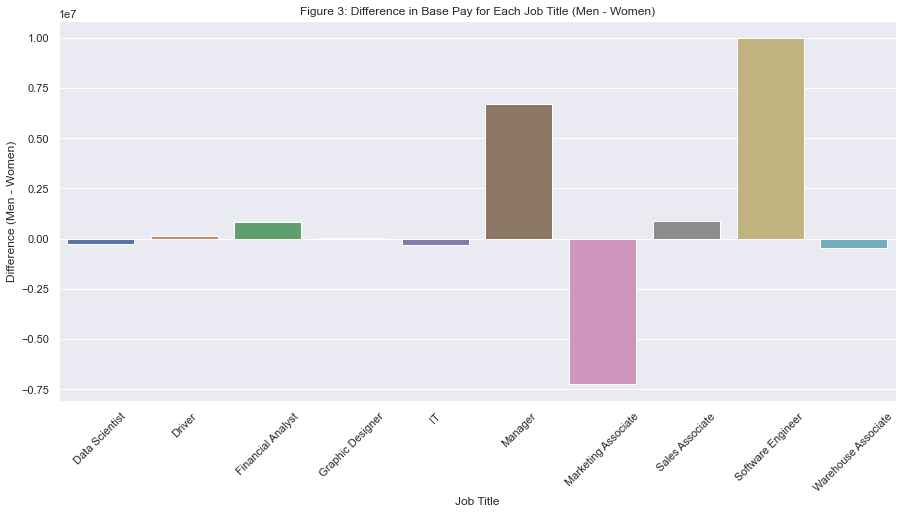

In [195]:
# Plot the data

df_female = df[df['Gender'] == 'Female']
df_male = df[df['Gender'] == 'Male']

female_totals = df_female.groupby('JobTitle').sum()
male_totals = df_male.groupby('JobTitle').sum()

plot = sns.barplot(data=df, x=male_totals.index, y=(male_totals['BasePay'] - female_totals['BasePay'])).set(title="Figure 3: Difference in Base Pay for Each Job Title (Men - Women)", xlabel = "Job Title", ylabel = "Difference (Men - Women)")
sns.set(rc={"figure.figsize":(15, 7)})
plt.xticks(rotation=45)
plt.show()

This bar plot gives us another way to visualize these gaps. A positve bar implies that men are paid more than women with the same job title, and how positive the value is corresponds to how big the gap is. Similarly, if the bar is negative, women are paid more on average in that field. There are more job titles where men are paid more, and these differences are often more significant than in those where women are paid more. Let's perform t-tests. 

In [194]:
# Get the job titles
job_titles = df["JobTitle"].unique()

# Perform the tests
for job_title in job_titles:
    
    print("Testing for {}s:".format(job_title))
    
    # Split the df
    male_base_pay = df[(df["Gender"] == "Male") & (df["JobTitle"] == job_title)]["BasePay"]
    female_base_pay = df[(df["Gender"] == "Female") & (df["JobTitle"] == job_title)]["BasePay"]
    
    print(perform_t_test(male_base_pay, female_base_pay))
    print()

Testing for Graphic Designers:
Failed to reject the null hypothesis; there is no significant difference between the sample means.

Testing for Software Engineers:
Failed to reject the null hypothesis; there is no significant difference between the sample means.

Testing for Warehouse Associates:
Failed to reject the null hypothesis; there is no significant difference between the sample means.

Testing for ITs:
Failed to reject the null hypothesis; there is no significant difference between the sample means.

Testing for Sales Associates:
Failed to reject the null hypothesis; there is no significant difference between the sample means.

Testing for Drivers:
Failed to reject the null hypothesis; there is no significant difference between the sample means.

Testing for Financial Analysts:
Failed to reject the null hypothesis; there is no significant difference between the sample means.

Testing for Marketing Associates:
Failed to reject the null hypothesis; there is no significant differe

Looking at individual job titles, there are no significant differences. 

#### How does annual base pay differ between genders in each department?

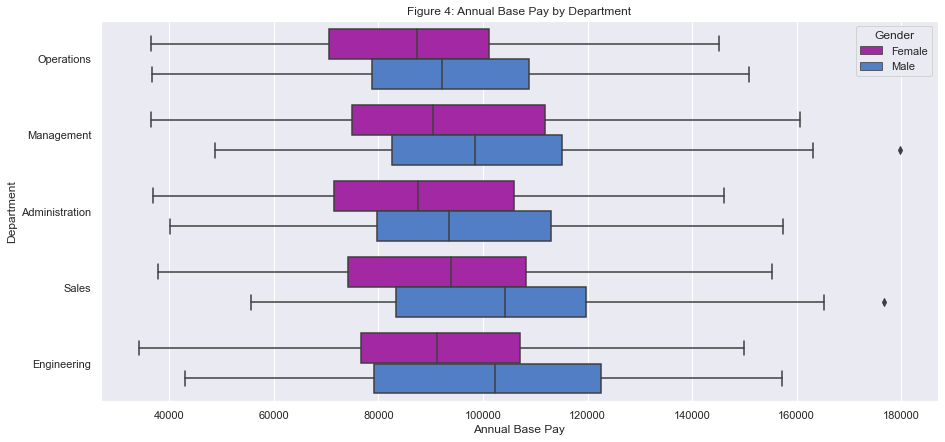

In [196]:
# Plot base pay by department

plot = sns.boxplot(data=df, x="BasePay", y="Dept", hue="Gender", palette = color_palette).set(title="Figure 4: Annual Base Pay by Department", xlabel = "Annual Base Pay", ylabel = "Department")
sns.set(rc={"figure.figsize":(15, 7)})

Here, we see that in every department, men are paid more than women. For each metric displayed by the boxplot (min, 25th percentile, median, 75th percentile, and max), the men in every department have a higher value than women in the same department. 

The data from all 3 graphs seems to tell the same story: in general, man are paid more than women in multiple differnt fields. 

### How does annual bonus pay differ between genders?

I do not expect this result to be very different from that of Question 1. To answer this question, I will look at overall plots and then break the data up by department, like in Figures 1 and 3. 

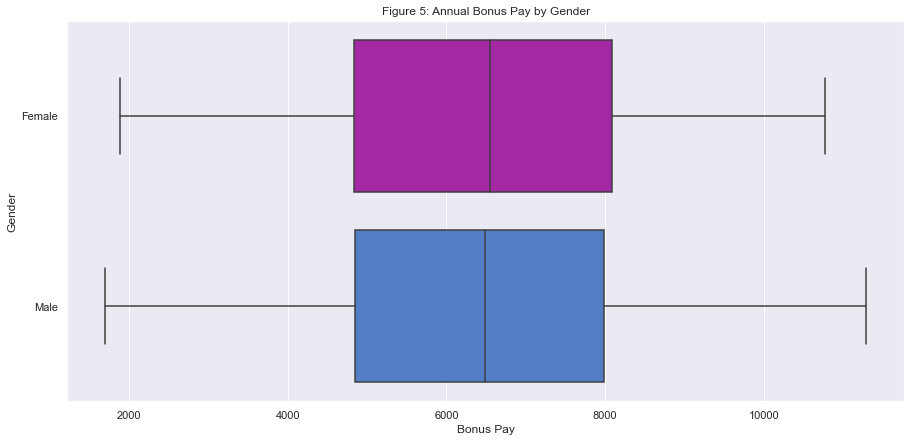

In [197]:
# Plot bonus pay by gender
plot = sns.boxplot(data=df, x="Bonus", y="Gender", palette = color_palette).set(title="Figure 5: Annual Bonus Pay by Gender", xlabel = "Bonus Pay")
sns.set(rc={"figure.figsize":(15, 7)})

In [206]:
# Check if there is a significant difference
male_bonus_pay = df[df["Gender"] == "Male"]["Bonus"]
female_bonus_pay = df[df["Gender"] == "Female"]["Bonus"]

print(perform_t_test(male_bonus_pay, female_bonus_pay))

Failed to reject the null hypothesis; there is no significant difference between the sample means.


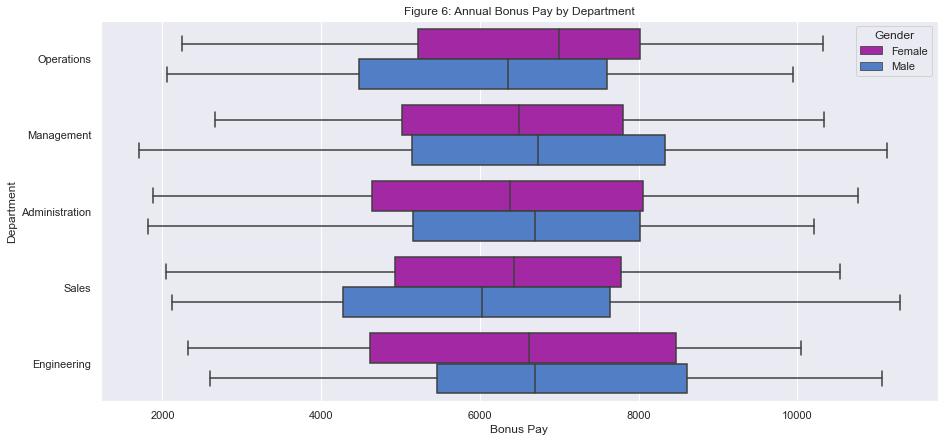

In [198]:
# Plot base pay by department
plot = sns.boxplot(data=df, x="Bonus", y="Dept", hue="Gender", palette = color_palette).set(title="Figure 6: Annual Bonus Pay by Department", xlabel = "Bonus Pay", ylabel = "Department")
sns.set(rc={"figure.figsize":(15, 7)})

In [205]:
departments = df["Dept"].unique()

# Check if any differences are significant
for department in departments:
    print("Testing for {} department:".format(department))

    # Split the df
    male_bonus_pay = df[(df["Gender"] == "Male") & (df["Dept"] == department)]["Bonus"]
    female_bonus_pay = df[(df["Gender"] == "Female") & (df["Dept"] == department)]["Bonus"]
    
    print(perform_t_test(male_bonus_pay, female_bonus_pay))
    print()

Testing for Operations department:
Reject the null hypothesis; there is a significant difference between the sample means.

Testing for Management department:
Failed to reject the null hypothesis; there is no significant difference between the sample means.

Testing for Administration department:
Failed to reject the null hypothesis; there is no significant difference between the sample means.

Testing for Sales department:
Failed to reject the null hypothesis; there is no significant difference between the sample means.

Testing for Engineering department:
Failed to reject the null hypothesis; there is no significant difference between the sample means.



There is no significant difference in bonus pay when looking at all departments combined; the boxplots are nearly identical for both genders. Interestingly, women are paid more in the Operations department; the first time we've observed a difference favoring women.  

### Combining base pay and bonus pay

I think it makes sense to combine annual base pay with bonus pay for a picture of total yearly earnings.

In [165]:
# Creating a new TotalEarnings column

# Function to calculate total earnings
def calculate_total_earnings(employee):
    return employee["BasePay"] + employee["Bonus"]

# Create a new TotalEarnings column by applying the function
df['TotalEarnings'] = df.apply(calculate_total_earnings, axis = 1) 

# Looking at the first few rows of the df
df.head(10)

,JobTitle,Gender,Age,PerfEval,Education,Dept,Seniority,BasePay,Bonus,TotalEarnings,Bin
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938,52301,2
1,Software Engineer,Male,21,5,College,Management,5,108476,11128,119604,12
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268,99476,9
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154,118234,11
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319,108783,10
5,IT,Female,20,5,PhD,Operations,4,70890,10126,81016,6
6,Graphic Designer,Female,20,5,College,Sales,4,67585,10541,78126,6
7,Software Engineer,Male,18,4,PhD,Engineering,5,97523,10240,107763,10
8,Graphic Designer,Female,33,5,High School,Engineering,5,112976,9836,122812,12
9,Sales Associate,Female,35,5,College,Engineering,5,106524,9941,116465,11


The new total earnings column will be used for the following questions. 

## Doing some investigation

### Is there a difference in total earnings between genders?

It would be valuable to plot this data and see what we're working with.

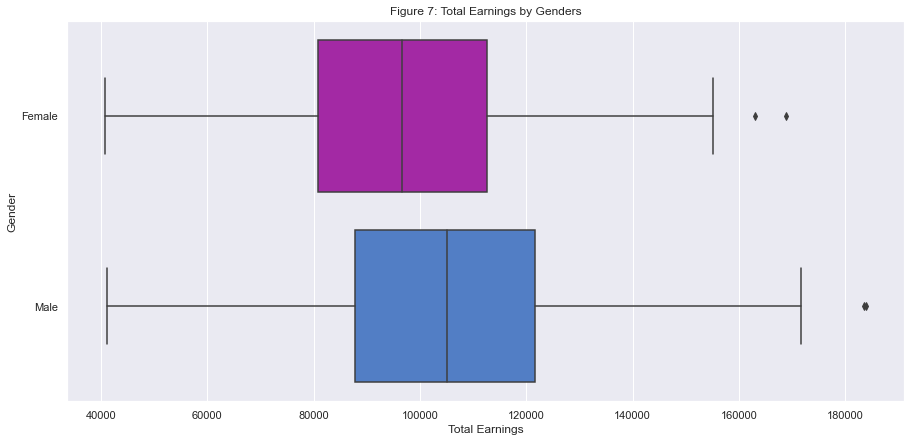

In [199]:
# Plot total earnings 
plot = sns.boxplot(data=df, x="TotalEarnings", y="Gender", palette = color_palette).set(title="Figure 7: Total Earnings by Genders", xlabel = "Total Earnings")
sns.set(rc={"figure.figsize":(15, 7)})

We also have the option of using a histogram to analyze this data. Doing so would help us visualize how earnings are distributed for each group and observe the frequencies linked to each range of salaries. We could stack or overlay the histograms for each gender, so let's try both. 

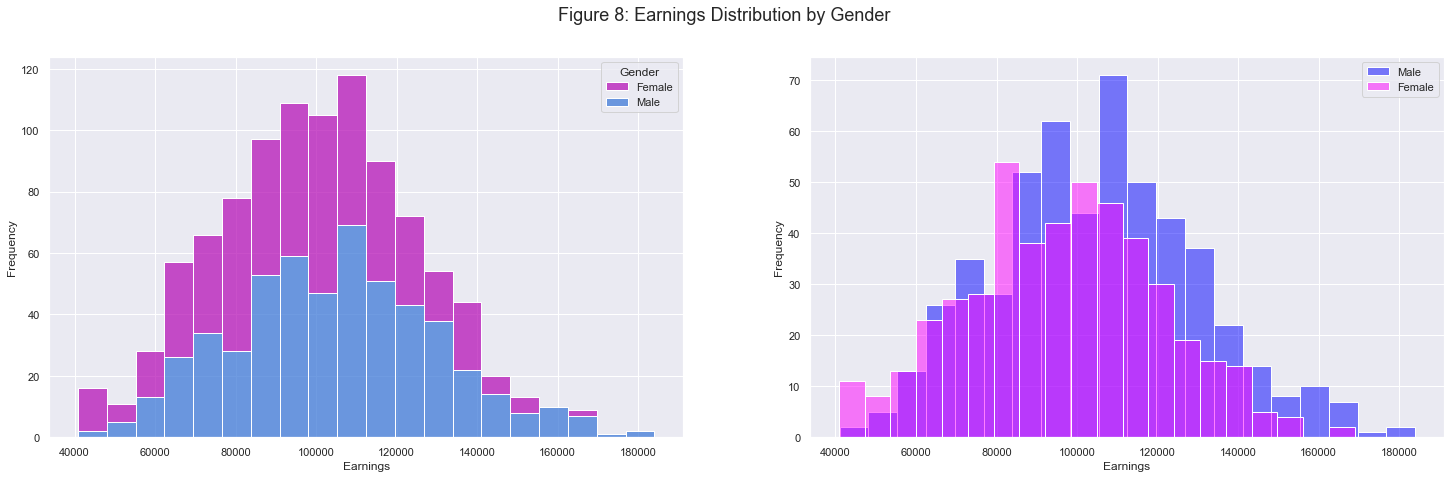

In [202]:
# Create a figure with two axes
fig, axes = plt.subplots(1, 2, figsize = (25, 7), sharex = False, sharey = False)

# Designate a title
fig.suptitle("Figure 8: Earnings Distribution by Gender", fontsize = 18)

# Stacked histogram on the first axis 
sns.histplot(ax = axes[0], data=df, x='TotalEarnings', hue='Gender', palette = color_palette, multiple='stack', bins=20).set(xlabel = "Earnings", ylabel = "Frequency")

# Overlayed histogram on the secons axis
sns.histplot(ax = axes[1], data=df[df['Gender'] == 'Male'], x='TotalEarnings', bins=20, color='blue', alpha=0.5, label='Male').set(xlabel = "Earnings", ylabel = "Frequency")
sns.histplot(ax = axes[1], data=df[df['Gender'] == 'Female'], x='TotalEarnings', bins=20, color='magenta', alpha=0.5, label='Female').set(xlabel = "Earnings", ylabel = "Frequency")
plt.legend()

In both cases, we see a higher frequency of female employees at the lower end of the histogram than at the higher end. In fact, only male employees earn above ~$170,000 a year. The difference can be seen clearly in the right-hand axis, where the histogram depicting women appears to be shifted slightly to the left of the histogram representing men. 

It would be value to perform a t-test to determine if the distance we observe from these plots is significant. 

In [150]:
# Split the df 
male_earnings = df[df["Gender"] == "Male"]["TotalEarnings"]
female_earnings = df[df["Gender"] == "Female"]["TotalEarnings"]

# Perform t-test
print(perform_t_test(male_earnings, female_earnings))

Reject the null hypothesis; there is a significant difference between the sample means.


As expected, there is a statistically significant difference between average total male earnings and average total female earnings. 

### Is there a difference in total earnings between genders if the same level of education has been achieved?

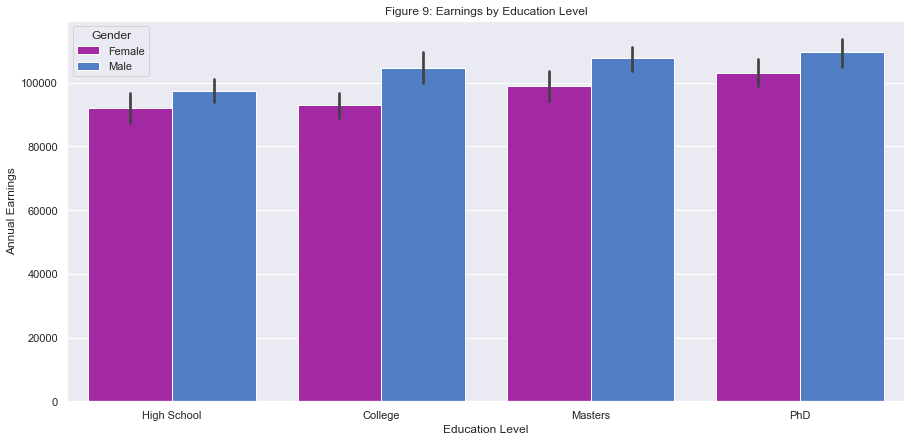

In [203]:
# Plot the data 
plot = sns.barplot(data=df, x="Education", y="TotalEarnings", hue="Gender", palette = color_palette, order=['High School', 'College', 'Masters', 'PhD']).set(title="Figure 9: Earnings by Education Level", xlabel = "Education Level", ylabel = "Annual Earnings")
sns.set(rc={"figure.figsize":(15, 7)})

In [204]:
# Test for signifiicance 
education_levels = df["Education"].unique()

for education_level in education_levels:
    print("Testing for {} level:".format(education_level))

    # Split the df
    male_earnings = df[(df["Gender"] == "Male") & (df["Education"] == education_level)]["TotalEarnings"]
    female_earnings = df[(df["Gender"] == "Female") & (df["Education"] == education_level)]["TotalEarnings"]
    
    print(perform_t_test(male_earnings, female_earnings))
    print()

Testing for College level:
Reject the null hypothesis; there is a significant difference between the sample means.

Testing for PhD level:
Failed to reject the null hypothesis; there is no significant difference between the sample means.

Testing for Masters level:
Reject the null hypothesis; there is a significant difference between the sample means.

Testing for High School level:
Failed to reject the null hypothesis; there is no significant difference between the sample means.



In Figure 8, we see education level on the x-axis and total earnings (with error bars) on the y-axis. Just looking at the data, the most significant difference is observed with college graduates, where there is nearly no overlap between the error bars. T-tests show that at the college and Masters levels, men earn significantly more than women who have achieved the same level of education. 

### Is there a difference in total earnings between genders if they have the same seniority level?

I think that seniority is a reliable indicator of how much an employee should be earning, since their years of experience in the industry often correlate with their expected compensation. Are there pay gaps between men and women with the same years of experience?

Seniority is ranked from 1 to 5, so it is treated like a numerical variable by pandas. It's best that I convert this column to strings so it can be treated like a categorical variable. I will do the same for the Performance Evaluation column, which is also ranked on a scale from 1 to 5.

In [166]:
# Making seniority and Performance Evaluation Score categorical variables 
df['Seniority'] = df['Seniority'].astype(str)
df['PerfEval'] = df['PerfEval'].astype(str)
df.dtypes

JobTitle           object
Gender             object
Age                 int64
PerfEval           object
Education          object
Dept               object
Seniority          object
BasePay             int64
Bonus               int64
TotalEarnings       int64
Bin              category
dtype: object

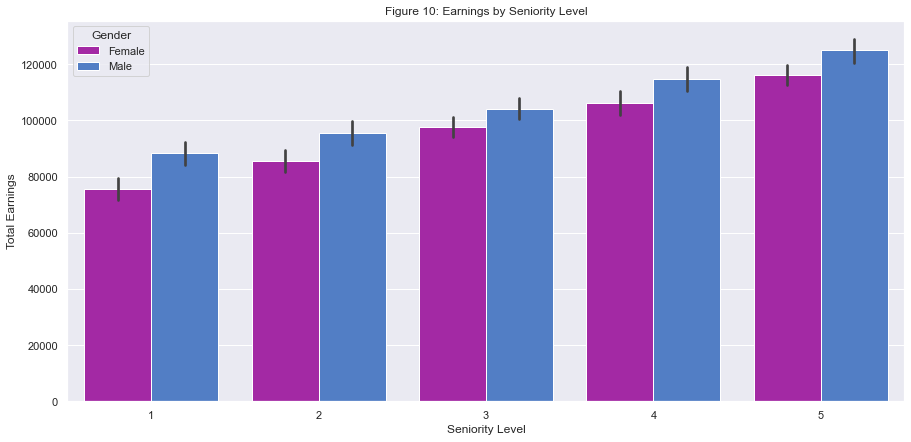

Testing for level 1:
Reject the null hypothesis; there is a significant difference between the sample means.

Testing for level 2:
Reject the null hypothesis; there is a significant difference between the sample means.

Testing for level 3:
Reject the null hypothesis; there is a significant difference between the sample means.

Testing for level 4:
Reject the null hypothesis; there is a significant difference between the sample means.

Testing for level 5:
Reject the null hypothesis; there is a significant difference between the sample means.



In [207]:
# Plot the data
plot = sns.barplot(data=df, x="Seniority", y="TotalEarnings", hue="Gender", palette = color_palette, order=['1', '2', '3', '4', '5']).set(title="Figure 10: Earnings by Seniority Level", xlabel = "Seniority Level", ylabel = "Total Earnings")
sns.set(rc={"figure.figsize":(15, 7)})
plt.show()

# Test for significance
for i in range(1, 6):
    
    seniority_level = str(i)
    print("Testing for level {}:".format(seniority_level))

    # Split the df
    male_earnings = df[(df["Gender"] == "Male") & (df["Seniority"] == seniority_level)]["TotalEarnings"]
    female_earnings = df[(df["Gender"] == "Female") & (df["Seniority"] == seniority_level)]["TotalEarnings"]
    
    print(perform_t_test(male_earnings, female_earnings))
    print()

We continue to see that men are paid higher all across the board. In some cases, women are even paid less than their male counterparts at lower seniority levels; level 2 women are paid less than level 1 men. In other cases, woman are paid the same as men at lower seniority levels; level 3, 4, and 5 woman are paid about the same as level 2, 3, and 4 men, respectively. 

### Is there a difference in total earnings between men and women the same performance evaluation score?

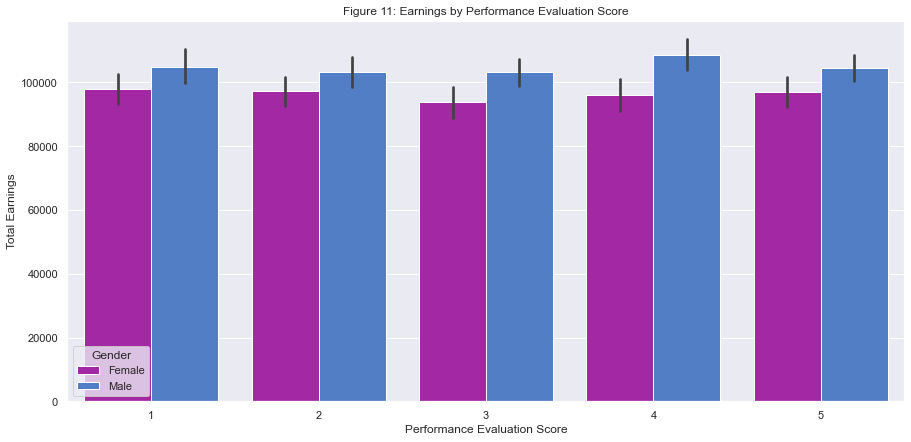

In [208]:
# Plot the data
plot = sns.barplot(data=df, x="PerfEval", y="TotalEarnings", hue="Gender", palette = color_palette, order=['1', '2', '3', '4', '5']).set(title="Figure 11: Earnings by Performance Evaluation Score", xlabel = "Performance Evaluation Score", ylabel = "Total Earnings")

sns.set(rc={"figure.figsize":(15, 7)})

It doesn't look like this variable has an effect on annual base pay at all; men are paid around the same for every score, and there is only a slight variation for women. Based on this dataset, performance evaluation has little influence on how much an employer pays its employees.

### As seniority increases, do both genders see a similar rise in annual base pay?

Figure 9 started to answer this question, but I think Seaborn's pointplot is a better way to visualize how the increase differs between genders. 

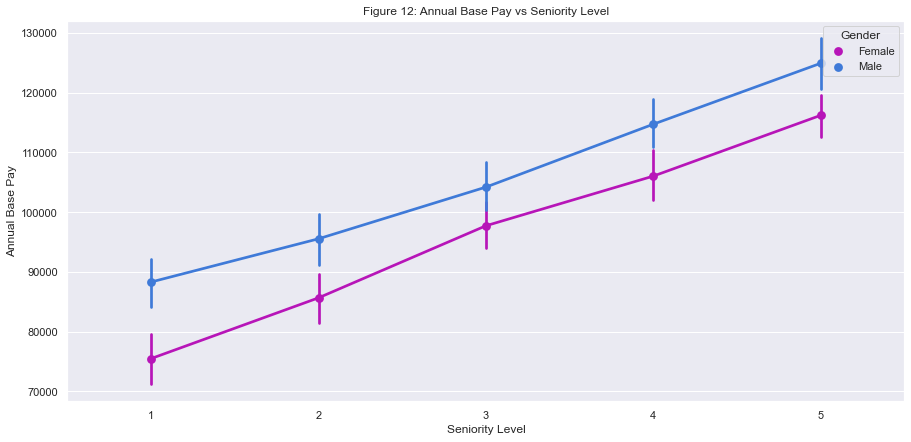

In [209]:
# Plot the data
plot = sns.pointplot(data=df, x="Seniority", y="TotalEarnings", hue="Gender", palette = color_palette, order=['1', '2', '3', '4', '5']).set(title="Figure 12: Annual Base Pay vs Seniority Level", xlabel = "Seniority Level", ylabel = "Annual Base Pay")
sns.set(rc={"figure.figsize":(15, 7)})

This result is as expected. 

In conclusion, this exploration has highlighted several substantial disparities in earnings between men and women. Across various educational levels and experience categories, the findings consistently point to a significant gender pay gap, with men consistently earning notably more than their female counterparts. These discrepancies underscore the importance of addressing gender-based wage disparities, fostering equal opportunities, and implementing strategies to rectify these imbalances. The insights gained from this exploration call for continued efforts to create a fair and equitable work environment that values and compensates individuals based on their skills, qualifications, and contributions, irrespective of gender. As we move forward, this study serves as a reminder of the work that remains to be done in pursuit of a more inclusive and just society.